# Predictions on bike rental usage

- Inputs: 
    - dteday: date 
    - season: (1 spring; 2 summer; 3 fall; 4 winter)
    - year: (0:2011 ; 1:2012)
    - hour: (0 to 23)
    - month: (1 to 12)
    - holiday: whether day is holiday or not (1 or 0)
    - weekday: day of week
    - weather: 
            - 1: clear, few clouds, partly cloudy 
            - 2: Mist + Cloudy, mist + broken clouds, mist + few clouds, mist
            - 3: Light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds
            - 4: Heavy rain + ice pallets + thunderstorm + mist, snow + fog
    - situation
    - temperature: normalized T in celcius. divided by max value 41
    - windspeed: normalized windspeed, divided by max(67)

- Outputs: 
    - casual (count of casual users)
    - registered (count of registered users)
    - cnt (count of total rental bikes including both casual and registered)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
df = pd.read_csv('bike_sharing_daily.csv')

# Data visualization

In [4]:
print(df.isnull().sum())
df.info()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  hum         731 non-null    float64
 11  windspeed   731 non-null    float64
 12  casual      731 non-null    int64  
 13  registered  731 non-nu

In [5]:
df['dteday'] = pd.to_datetime(df['dteday'])
df.index= df['dteday']
df= df.drop(labels= ['dteday','instant', 'casual', 'registered'], axis = 1)
df.head()


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
dteday,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.805833,0.160446,985
2011-01-02,1,0,1,0,0,0,2,0.363478,0.696087,0.248539,801
2011-01-03,1,0,1,0,1,1,1,0.196364,0.437273,0.248309,1349
2011-01-04,1,0,1,0,2,1,1,0.200000,0.590435,0.160296,1562
2011-01-05,1,0,1,0,3,1,1,0.226957,0.436957,0.186900,1600


### Usage of rental bikes from 2011/01 to 2013/01

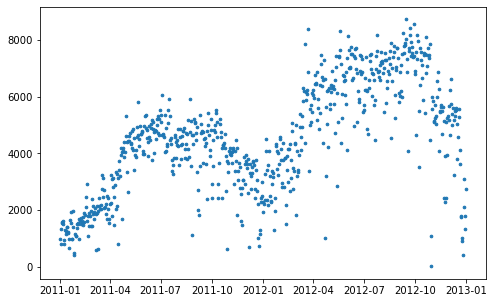

In [6]:
plt.figure(figsize=(8,5))
plt.scatter(df.index, df['cnt'],s = 7 )

<AxesSubplot:xlabel='dteday'>

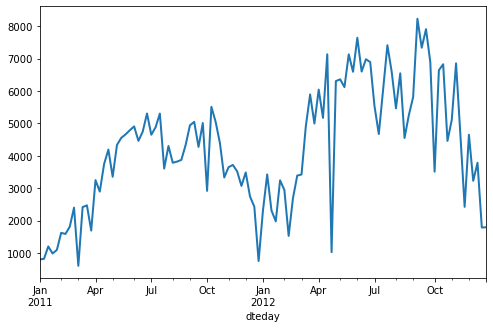

In [7]:
plt.figure(figsize=(8,5))
df['cnt'].asfreq('W').plot(linewidth=2)

It can be seen that in the summer there are a greater number of bicycle rentals

Lets plot a pairplot to see the correlations between the different variables:

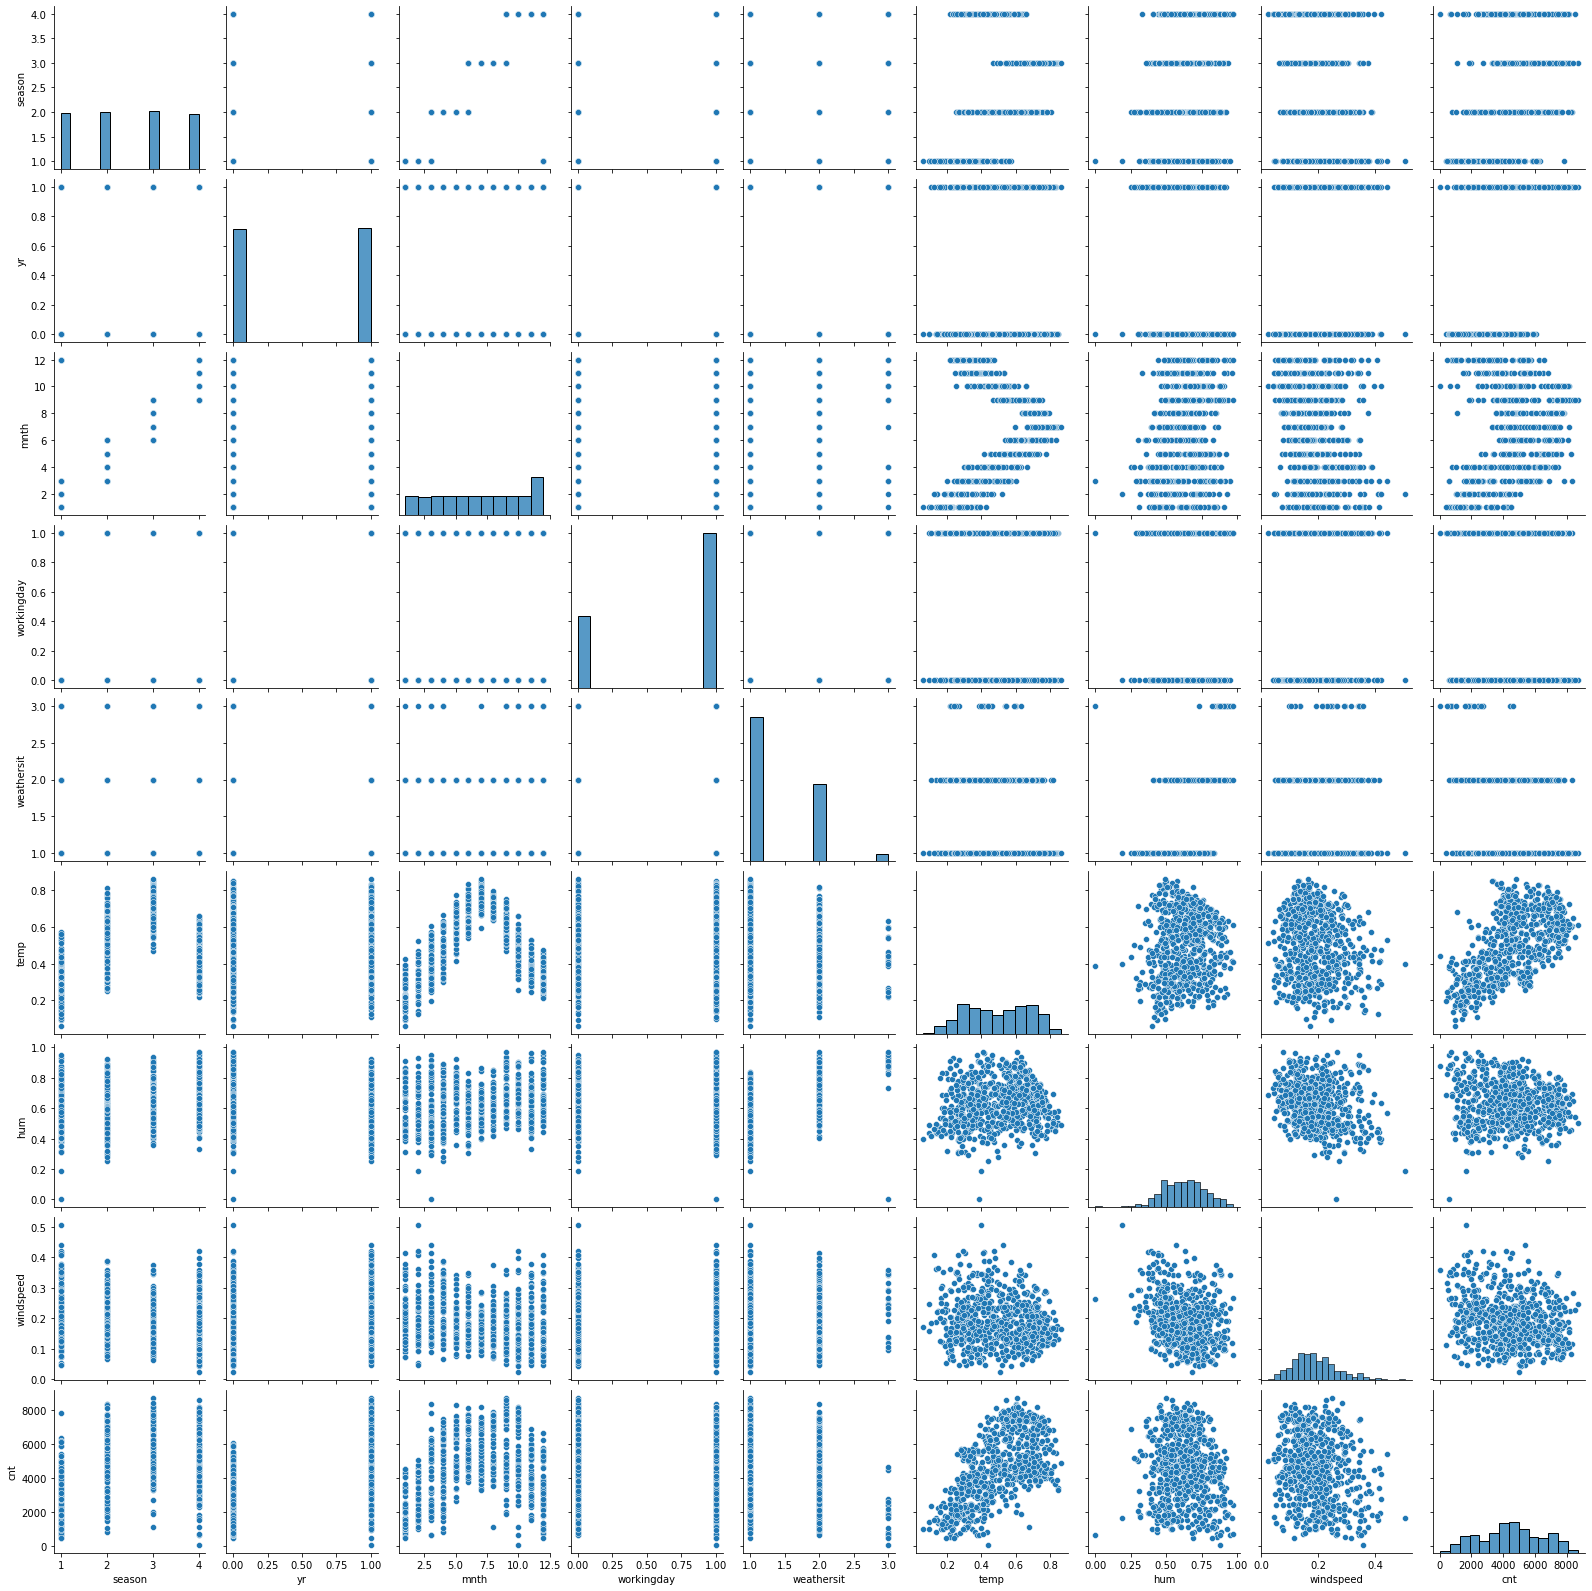

In [8]:
sns.pairplot(df, vars=[ 'season', 'yr', 'mnth',
       'workingday', 'weathersit', 'temp', 'hum', 'windspeed','cnt'])

It can be seen that the weather has correlation with the count of bikes rented per day

Lets see the weather for each day through the data and the count of bikes rented:

<AxesSubplot:xlabel='dteday', ylabel='cnt'>

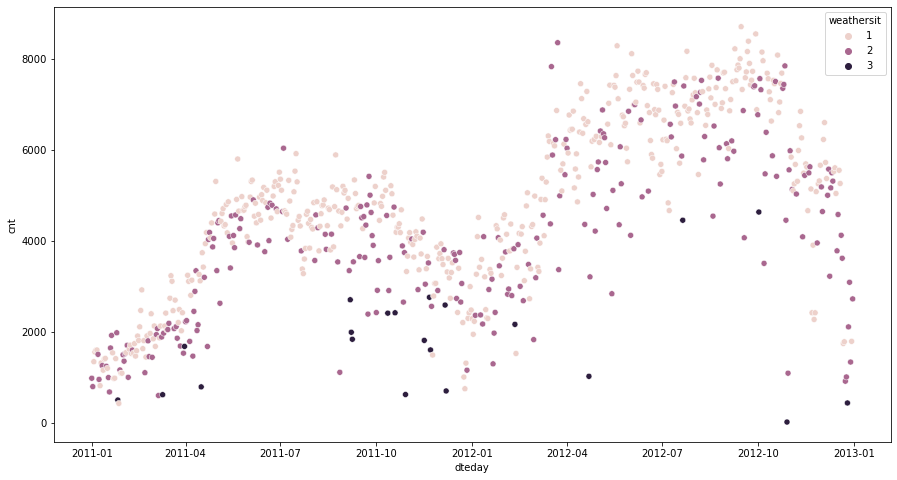

In [9]:
plt.figure(figsize=(15,8))
sns.scatterplot(data = df, x= 'dteday', y = 'cnt', hue='weathersit')

The temperature vs count of bikes rented:

<AxesSubplot:xlabel='temp', ylabel='cnt'>

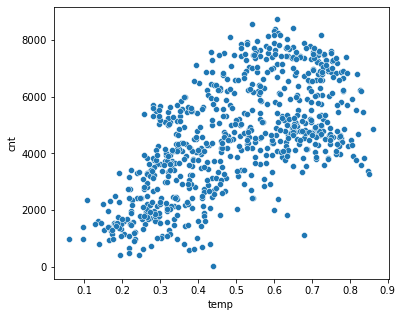

In [10]:
plt.figure(figsize=(6,5))
sns.scatterplot(data = df, x = 'temp' , y = 'cnt')

As temperature increases the rents increase

Lets see the windspeed:

<AxesSubplot:xlabel='windspeed', ylabel='cnt'>

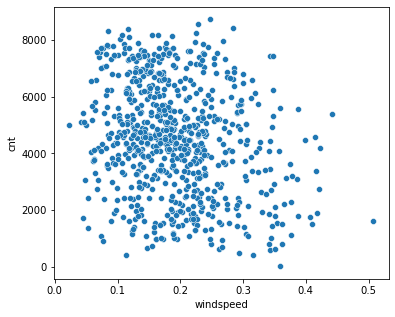

In [11]:
plt.figure(figsize=(6,5))
sns.scatterplot(data = df, x = 'windspeed' , y = 'cnt')

As windspeed increases the rents decrease

### Let's see if there is a variation in amount of bicycles rented between weekdays and weekends

Avarage rented bikes per day on workdays and weekends:

<AxesSubplot:title={'center':'Amount of bicycles rented on average per day'}>

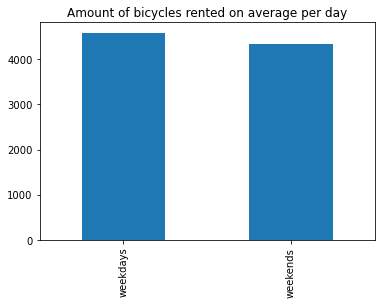

In [12]:
workday = df.query('workingday == 1')
weekend = df.query('workingday == 0')
values = pd.DataFrame([workday['cnt'].mean(), weekend['cnt'].mean()], index= ['weekdays','weekends'], columns=['N'])
values['N'].plot(kind='bar', title='Amount of bicycles rented on average per day')

It can be seen that on average more bicycles are rented on a weekday

It can be viewed in percentages also:

([<matplotlib.patches.Wedge at 0x16d8b04fac0>,
 [Text(-0.049339272812686796, 1.0988929138721004, 'average bikes rented on a working day'),
  Text(0.0493395814700247, -1.0988929000136287, 'average bikes rented on a weekend day')],
 [Text(-0.026912330625101885, 0.5993961348393274, '51.4%'),
  Text(0.02691249898364983, -0.599396127280161, '48.6%')])

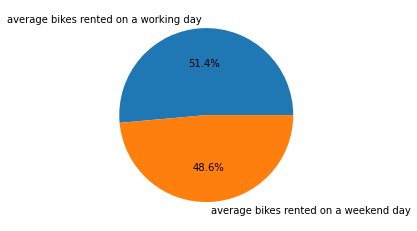

In [13]:
workday = df.query('workingday == 1')
weekend = df.query('workingday == 0')
values = [workday['cnt'].mean(), weekend['cnt'].mean()]
plt.pie(values, labels=['average bikes rented on a working day','average bikes rented on a weekend day' ],autopct='%1.1f%%')
# plt.title("Com")

And if its raining:

In [14]:
avg_raining_workday = workday['cnt'][workday['weathersit']>2].mean()
avg_raining_weekend = weekend['cnt'][weekend['weathersit']>2].mean()

<AxesSubplot:title={'center':'Amount of bicycles rented on average per day'}>

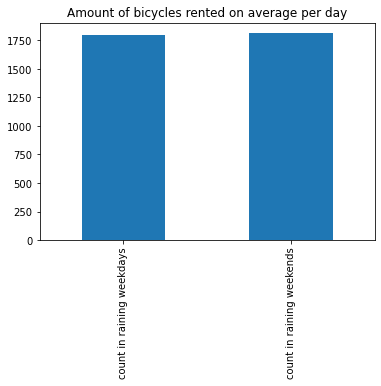

In [15]:
values = pd.DataFrame([avg_raining_workday, avg_raining_weekend], index= ['count in raining weekdays','count in raining weekends'], columns=['N'])
values['N'].plot(kind='bar', title='Amount of bicycles rented on average per day')

It can be seen that when it's raining the average demand for bicycles is greater on weekends

It can be viewed in percentages also:

([<matplotlib.patches.Wedge at 0x16d8b0f1ac0>,
 [Text(0.0075998387507007666, 1.0999737462553203, 'count rented bikes inraining weekdays'),
  Text(-0.0075997357637262045, -1.0999737469668636, 'count rented bikes in raining weekends')],
 [Text(0.004145366591291327, 0.5999856797756291, '49.8%'),
  Text(-0.004145310416577929, -0.5999856801637438, '50.2%')])

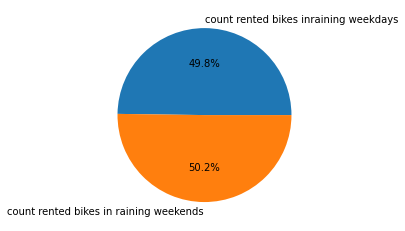

In [16]:
plt.pie ([avg_raining_workday,
        avg_raining_weekend],
          labels= ['count rented bikes inraining weekdays', 'count rented bikes in raining weekends'], autopct='%1.1f%%')

Number of bicycles rented on business days according to the weather:

<AxesSubplot:xlabel='workingday', ylabel='cnt'>

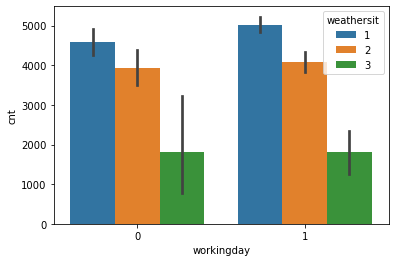

In [18]:
sns.barplot(data = df, x= 'workingday', y= 'cnt', hue = 'weathersit')

As expected, on days when the weather is nice there are more bike rentals.

Correlation matrix between climate and number of rented bicycles:

<AxesSubplot:>

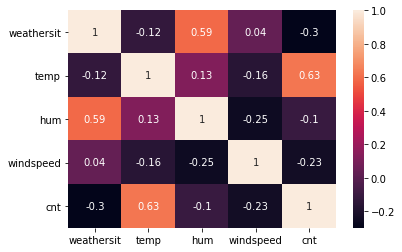

In [19]:
weather = df[['weathersit', 'temp', 'hum', 'windspeed', 'cnt']]
corr = weather.corr()
sns.heatmap(corr, annot= True)

Correlation matrix for all variables:

<AxesSubplot:>

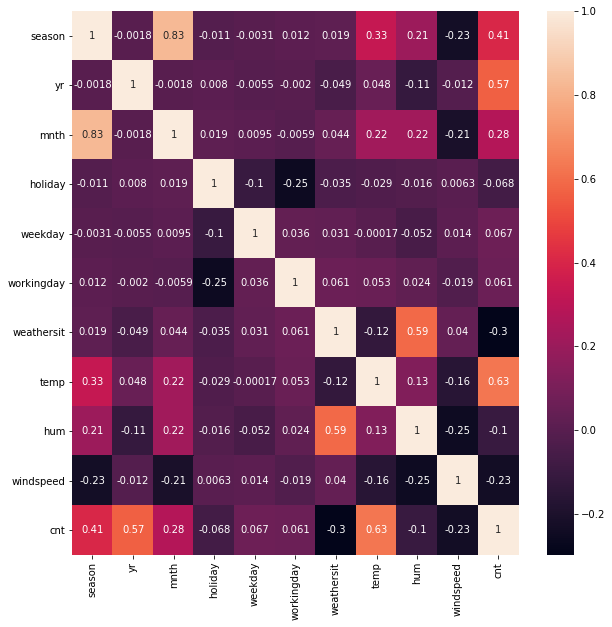

In [20]:
plt.figure(figsize = (10,10))
sns.heatmap(df.corr(), annot=True)

### Prepare data for training and testing:

In [21]:
df = df.reset_index()

In [22]:
df_numerical = df[['temp', 'hum', 'windspeed', 'cnt']]
df_categorical = df[['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']]

In [23]:
df_categorical = pd.get_dummies(df_categorical,dtype=int, columns=['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'])

In [24]:
df = pd.concat([df_categorical, df_numerical] , axis=1)
df

,season_1,season_2,season_3,season_4,yr_0,yr_1,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,holiday_0,holiday_1,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,temp,hum,windspeed,cnt
0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0.344167,0.805833,0.160446,985
1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0.363478,0.696087,0.248539,801
2,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0.196364,0.437273,0.248309,1349
3,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0.200000,0.590435,0.160296,1562
4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0.226957,0.436957,0.186900,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0.254167,0.652917,0.350133,2114
727,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0.253333,0.590000,0.155471,3095
728,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0.253333,0.752917,0.124383,1341
729,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0.255833,0.483333,0.350754,1796


In [25]:
x = df.drop('cnt', axis = 1)
y = df[['cnt']]

Split data into training and testing

In [26]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [27]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(584, 35)
(584, 1)
(147, 35)
(147, 1)


## Train XGBOOST algorithm

First we train and predict using XGBoost algorithm

In [28]:
model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate = 1, max_depth = 8, n_estimators = 500)
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [29]:
result = model.score(x_test,y_test)
print("accuracy: {}".format(result))

accuracy: 0.8519512301474998


In [30]:
y_predict = model.predict(x_test)

In [31]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
k = x_test.shape[1]
n = len(x_test)
RMSE = float(format(np.sqrt(mean_squared_error(y_test, y_predict)),'.3f'))
MSE = mean_squared_error(y_test, y_predict)
MAE = mean_absolute_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 791.461 
MSE = 626411.0318749162 
MAE = 573.800140588462 
R2 = 0.8519512301474998 
Adjusted R2 = 0.8052691855994142


Now we try to obtain better results by doing hyperparameters optimization with gridsearch:

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
parameters_grid = {'max_depth': [3,6,10],
                   'learning_rate': [0.01,0.05,0.1],
                   'n_estimators': [100,500,1000],
                   'colsample_bytree': [0.3,0.6,1],
                   'gamma' : [1, 0.1, 0.01]

                }

In [34]:
xgb_gridsearch = GridSearchCV( estimator= model,
                              param_grid= parameters_grid,
                              scoring = 'neg_mean_squared_error',
                              cv = 5,
                              verbose = 5
                              )

In [35]:
xgb_gridsearch.fit(x_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 1/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.1s
[CV 4/5] END colsample_b

[CV 2/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=1000; total time=   0.5s
[CV 3/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=1000; total time=   0.5s
[CV 4/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=1000; total time=   0.5s
[CV 5/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=1000; total time=   0.5s
[CV 1/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.05, max_depth=10, n_estimators=100; total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.05, max_depth=10, n_estimators=100; total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.05, max_depth=10, n_estimators=100; total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.05, max_depth=10, n_estimators=100; total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=1, learning_rate=0.05, max_depth=10, n_

[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.1s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=1000; total time=   0.3s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=1000; total time=   0.3s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=1000; total time=   0.3s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=1000; total time=   0.3s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=1000; total time=   0.3s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.01, max_depth=6, n_estimators=100; total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.01, max_depth=6, n_estimators=100; total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.01, m

[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, n_estimators=500; total time=   0.5s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, n_estimators=500; total time=   0.4s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, n_estimators=500; total time=   0.5s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, n_estimators=500; total time=   0.5s
[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, n_estimators=500; total time=   0.4s
[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, n_estimators=1000; total time=   0.8s
[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, n_estimators=1000; total time=   0.8s
[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, n_estimators=1000; total time=   0.8s
[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0

[CV 4/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=100; total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=100; total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=500; total time=   0.2s
[CV 2/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=500; total time=   0.2s
[CV 3/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=500; total time=   0.2s
[CV 4/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=500; total time=   0.2s
[CV 5/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=500; total time=   0.2s
[CV 1/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=1000; total time=   0.5s
[CV 2/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.

[CV 4/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=10, n_estimators=1000; total time=   0.8s
[CV 5/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=10, n_estimators=1000; total time=   1.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV 2/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV 3/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV 4/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV 5/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=500; total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.1, 

[CV 5/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=500; total time=   0.3s
[CV 1/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=1000; total time=   0.6s
[CV 2/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=1000; total time=   0.6s
[CV 3/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=1000; total time=   0.6s
[CV 4/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=1000; total time=   0.6s
[CV 5/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=1000; total time=   0.6s
[CV 1/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=10, n_estimators=100; total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=10, n_estimators=100; total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.01, max_depth=10, n_e

[CV 2/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=500; total time=   0.1s
[CV 3/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=500; total time=   0.1s
[CV 4/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=500; total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=500; total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=1000; total time=   0.3s
[CV 2/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=1000; total time=   0.3s
[CV 3/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=1000; total time=   0.3s
[CV 4/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=1000; total time=   0.3s
[CV 5/5] END colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=100

[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100; total time=   0.1s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=100; total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=500; total time=   0.7s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=500; total time=   0.7s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=500; total time=   0.7s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=500; total time=   0.7s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=500; total time=   0.7s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=1000; total time=   1.4s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.0

[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=1000; total time=   0.3s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=500; total time=   0.3s
[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=500; total time=   0.3s
[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=6, n

[CV 1/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.01, max_depth=10, n_estimators=1000; total time=   1.5s
[CV 2/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.01, max_depth=10, n_estimators=1000; total time=   1.6s
[CV 3/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.01, max_depth=10, n_estimators=1000; total time=   1.7s
[CV 4/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.01, max_depth=10, n_estimators=1000; total time=   1.7s
[CV 5/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.01, max_depth=10, n_estimators=1000; total time=   2.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0.01, learnin

[CV 1/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.1, max_depth=6, n_estimators=500; total time=   0.2s
[CV 2/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.1, max_depth=6, n_estimators=500; total time=   0.2s
[CV 3/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.1, max_depth=6, n_estimators=500; total time=   0.2s
[CV 4/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.1, max_depth=6, n_estimators=500; total time=   0.2s
[CV 5/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.1, max_depth=6, n_estimators=500; total time=   0.2s
[CV 1/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.1, max_depth=6, n_estimators=1000; total time=   0.5s
[CV 2/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.1, max_depth=6, n_estimators=1000; total time=   0.5s
[CV 3/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.1, max_depth=6, n_estimators=1000; total time=   0.5s
[CV 4/5] END colsample_bytree=0.6, gamma=0.01, learning_rate=0.1, max

[CV 5/5] END colsample_bytree=1, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.0s
[CV 1/5] END colsample_bytree=1, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=500; total time=   0.1s
[CV 2/5] END colsample_bytree=1, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=500; total time=   0.1s
[CV 3/5] END colsample_bytree=1, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=500; total time=   0.1s
[CV 4/5] END colsample_bytree=1, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=500; total time=   0.1s
[CV 5/5] END colsample_bytree=1, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=500; total time=   0.1s
[CV 1/5] END colsample_bytree=1, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=1000; total time=   0.3s
[CV 2/5] END colsample_bytree=1, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=1000; total time=   0.3s
[CV 3/5] END colsample_bytree=1, gamma=1, learning_rate=0.05, max_depth=3, n_estimators=1000; total ti

[CV 4/5] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=100; total time=   0.1s
[CV 5/5] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=100; total time=   0.1s
[CV 1/5] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=500; total time=   0.2s
[CV 2/5] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=500; total time=   0.2s
[CV 3/5] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=500; total time=   0.2s
[CV 4/5] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=500; total time=   0.2s
[CV 5/5] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=500; total time=   0.2s
[CV 1/5] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=1000; total time=   0.4s
[CV 2/5] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=10, n_estimators=1000; total tim

[CV 3/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=100; total time=   0.0s
[CV 4/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=100; total time=   0.0s
[CV 5/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=100; total time=   0.0s
[CV 1/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=500; total time=   0.3s
[CV 2/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=500; total time=   0.3s
[CV 3/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=500; total time=   0.3s
[CV 4/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=500; total time=   0.3s
[CV 5/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=500; total time=   0.3s
[CV 1/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimator

[CV 5/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=10, n_estimators=1000; total time=   0.4s
[CV 1/5] END colsample_bytree=1, gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 2/5] END colsample_bytree=1, gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 3/5] END colsample_bytree=1, gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 4/5] END colsample_bytree=1, gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 5/5] END colsample_bytree=1, gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV 1/5] END colsample_bytree=1, gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.1s
[CV 2/5] END colsample_bytree=1, gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.1s
[CV 3/5] END colsample_bytree=1, gamma=0.01, learning_rate=0.01, max_depth=3, n_

[CV 1/5] END colsample_bytree=1, gamma=0.01, learning_rate=0.05, max_depth=6, n_estimators=1000; total time=   0.7s
[CV 2/5] END colsample_bytree=1, gamma=0.01, learning_rate=0.05, max_depth=6, n_estimators=1000; total time=   0.7s
[CV 3/5] END colsample_bytree=1, gamma=0.01, learning_rate=0.05, max_depth=6, n_estimators=1000; total time=   0.6s
[CV 4/5] END colsample_bytree=1, gamma=0.01, learning_rate=0.05, max_depth=6, n_estimators=1000; total time=   0.8s
[CV 5/5] END colsample_bytree=1, gamma=0.01, learning_rate=0.05, max_depth=6, n_estimators=1000; total time=   0.7s
[CV 1/5] END colsample_bytree=1, gamma=0.01, learning_rate=0.05, max_depth=10, n_estimators=100; total time=   0.1s
[CV 2/5] END colsample_bytree=1, gamma=0.01, learning_rate=0.05, max_depth=10, n_estimators=100; total time=   0.1s
[CV 3/5] END colsample_bytree=1, gamma=0.01, learning_rate=0.05, max_depth=10, n_estimators=100; total time=   0.1s
[CV 4/5] END colsample_bytree=1, gamma=0.01, learning_rate=0.05, max_dep

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=1, max_...
                                    max_depth=8, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=500,
                

In [36]:
xgb_gridsearch.best_params_

{'colsample_bytree': 0.6,
 'gamma': 1,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 500}

In [37]:
xgb_gridsearch.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
y_predict = xgb_gridsearch.predict(x_test)

In [39]:
k = x_test.shape[1]
n = len(x_test)
RMSE = float(format(np.sqrt(mean_squared_error(y_test, y_predict)),'.3f'))
MSE = mean_squared_error(y_test, y_predict)
MAE = mean_absolute_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 541.608 
MSE = 293339.609049402 
MAE = 397.7734532777955 
R2 = 0.9306708118808334 
Adjusted R2 = 0.9088102570684836
